<a href="https://colab.research.google.com/github/Edward-Eughene-Timothy/Walmart-Sales-Prediction/blob/main/Walmart_Sales_Prediction_using_ML_Algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Get the Dataset and import it

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("yasserh/walmart-dataset")

print("Path to dataset files:", path)

100%|██████████| 122k/122k [00:00<00:00, 55.8MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/yasserh/walmart-dataset/versions/1


## 2. Now we do the data preprocessing

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

dataset = pd.read_csv(path+"/Walmart.csv")

In [ ]:
df = pd.DataFrame(dataset)
df['Date'] = pd.to_datetime(df['Date'],format= "%d-%m-%Y")

df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week

df = df.drop(columns='Date')
df.dropna()
df.head(5)

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Week
0,1,1643690.90,0,42.31,2.572,211.096358,8.106,2010,2,5
1,1,1641957.44,1,38.51,2.548,211.242170,8.106,2010,2,6
2,1,1611968.17,0,39.93,2.514,211.289143,8.106,2010,2,7
3,1,1409727.59,0,46.63,2.561,211.319643,8.106,2010,2,8
4,1,1554806.68,0,46.50,2.625,211.350143,8.106,2010,3,9


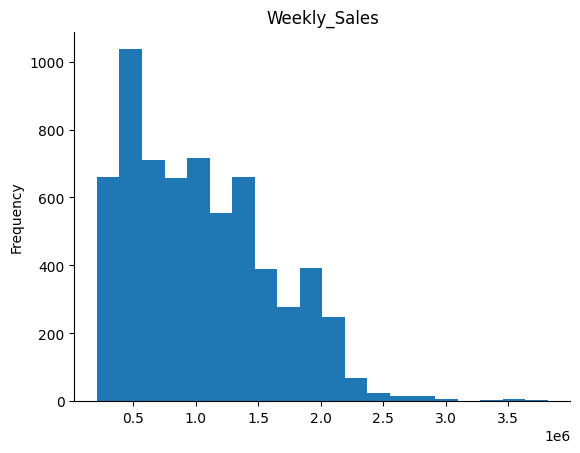

In [ ]:
from matplotlib import pyplot as plt
df['Weekly_Sales'].plot(kind='hist', bins=20, title='Weekly_Sales')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
correlation_matrix = df.corr()
print(correlation_matrix)

                     Store  Weekly_Sales  Holiday_Flag  Temperature  \
Store         1.000000e+00     -0.335332 -4.386841e-16    -0.022659   
Weekly_Sales -3.353320e-01      1.000000  3.689097e-02    -0.063810   
Holiday_Flag -4.386841e-16      0.036891  1.000000e+00    -0.155091   
Temperature  -2.265908e-02     -0.063810 -1.550913e-01     1.000000   
Fuel_Price    6.002295e-02      0.009464 -7.834652e-02     0.144982   
CPI          -2.094919e-01     -0.072634 -2.162091e-03     0.176888   
Unemployment  2.235313e-01     -0.106176  1.096028e-02     0.101158   
Year          3.474318e-12     -0.018378 -5.678257e-02     0.064269   
Month         2.910676e-15      0.076143  1.229958e-01     0.235862   
Week          3.106283e-15      0.074211  1.277427e-01     0.236183   

              Fuel_Price       CPI  Unemployment          Year         Month  \
Store           0.060023 -0.209492      0.223531  3.474318e-12  2.910676e-15   
Weekly_Sales    0.009464 -0.072634     -0.106176 -1.837754

In [ ]:
x=df.drop(columns="Weekly_Sales")
y=df["Weekly_Sales"]

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=1)

## 3.Now we create a model

In [ ]:
! pip install xgboost


In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

param_grid = {
    'n_estimators': [500, 1000],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

xgb = XGBRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(x_train, y_train)

print("✅ Best Hyperparameters:", grid_search.best_params_)
print("📉 Best Negative MAE Score:", grid_search.best_score_)


Fitting 3 folds for each of 32 candidates, totalling 96 fits
✅ Best Hyperparameters: {'colsample_bytree': 1, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 1000, 'subsample': 0.8}
📉 Best Negative MAE Score: -54071.13880962566


In [ ]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import numpy as np

In [ ]:
xgb_model = XGBRegressor(
    colsample_bytree=1,
    learning_rate=0.05,
    max_depth=5,
    n_estimators=1000,
    subsample=0.8,
    random_state=42)
xgb_model.fit(x_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [ ]:
rfr_model = RandomForestRegressor(n_estimators=1000,random_state=1)
rfr_model.fit(x_train,y_train)

RandomForestRegressor(n_estimators=1000, random_state=1)

## 4.Now we predict the performance

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [ ]:
from sklearn.model_selection import cross_val_score
mae_scores = cross_val_score(xgb_model, x, y, cv=5, scoring='neg_mean_absolute_error')
mae_scores = -mae_scores

print("Cross-Validated MAE scores:", mae_scores)
print("Average MAE:", np.mean(mae_scores))


Cross-Validated MAE scores: [639954.98823621 544070.9884965  394041.7968007  647653.74343046
 388656.34355041]
Average MAE: 522875.5721028554


In [ ]:
df_test = x_test.copy()
df_test["Holiday_Flag"] = x_test["Holiday_Flag"]

In [ ]:
#have to define wmae func here
def WMAE(df, targets, predictions):
    weights = df["Holiday_Flag"].apply(lambda x: 5 if x == 1 else 1)
    return np.round(np.sum(weights * abs(targets - predictions)) / np.sum(weights), 2)

In [ ]:
y_pred_xgb = xgb_model.predict(x_test)
y_pred_rfr = rfr_model.predict(x_test)

In [ ]:
def evaluate_performance(y_pred):
  mae = mean_absolute_error(y_test, y_pred)
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  r2 = r2_score(y_test, y_pred)
  wmae = WMAE(df_test, y_test, y_pred)

  print(f"Mean Absolute Error (MAE): {mae:.2f}")
  print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
  print(f"R² Score (Accuracy): {r2:.2f}")
  print(f"Weighted Mean Absolute Error (wMAE): {wmae:.2f}")

In [ ]:
evaluate_performance(y_pred_xgb)

Mean Absolute Error (MAE): 46823.26
Root Mean Squared Error (RMSE): 80897.01
R² Score (Accuracy): 0.98
Weighted Mean Absolute Error (wMAE): 54575.24


In [ ]:
evaluate_performance(y_pred_rfr)

Mean Absolute Error (MAE): 55761.49
Root Mean Squared Error (RMSE): 99986.83
R² Score (Accuracy): 0.97
Weighted Mean Absolute Error (wMAE): 67265.29


## 5. Fancy Visulizations just to show off

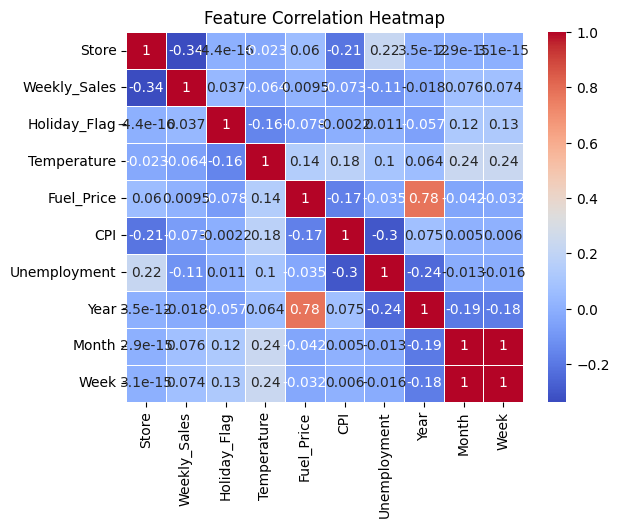

In [ ]:
import seaborn as sns
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

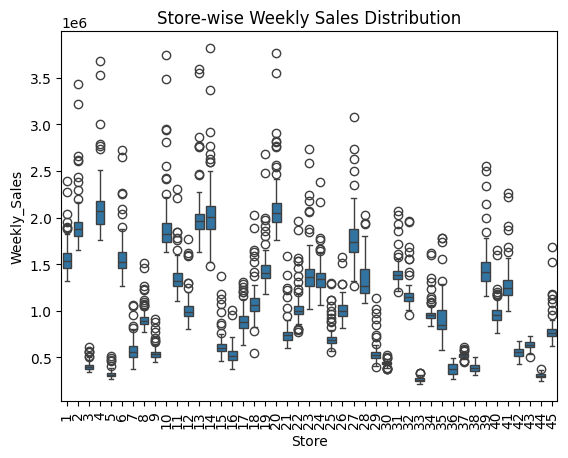

In [ ]:
sns.boxplot(x="Store", y="Weekly_Sales", data=df)
plt.title("Store-wise Weekly Sales Distribution")
plt.xticks(rotation=90)
plt.show()

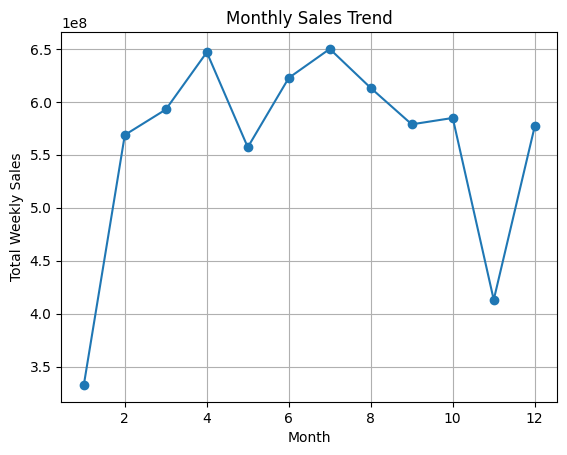

In [ ]:
import matplotlib.pyplot as plt

df.groupby('Month')['Weekly_Sales'].sum().plot(kind='line', marker='o')
plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Total Weekly Sales")
plt.grid(True)
plt.show()

In [ ]:
# 👇 Reordering columns exactly how model was trained
expected_columns = ['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price',
                    'CPI', 'Unemployment', 'Year', 'Month', 'Week']

test_input = pd.DataFrame([{
    'Store': 1,
    'Holiday_Flag': 0,
    'Temperature': 60.5,
    'Fuel_Price': 3.25,
    'CPI': 220.5,
    'Unemployment': 7.5,
    'Year': 2012,
    'Month': 11,
    'Week': 46
}], columns=expected_columns)

# Predict!
prediction = xgb_model.predict(test_input)
print(f"🛍️ Predicted Weekly Sales: ${prediction[0]:,.2f}")


🛍️ Predicted Weekly Sales: $1,614,781.00
